# Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


ImportError: No module named cv2

# File Extract & Sort

In [28]:
file_names = os.listdir("../input/Train/")
file_names = sorted(file_names, key=lambda 
                    item: (int(item.partition('.')[0]) if item[0].isdigit() else float('inf'), item))

# select a subset of files to run on
file_names = file_names[0:20]

In [29]:
file_names

['0.jpg',
 '1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg',
 '10.jpg',
 '41.jpg',
 '42.jpg',
 '43.jpg',
 '44.jpg',
 '45.jpg',
 '46.jpg',
 '47.jpg',
 '48.jpg',
 '49.jpg']

#  Extract Coordinate of Dotted SeaLion

In [15]:
# dataframe to store coordinate results in
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups"]
coordinates_df = pd.DataFrame(index=file_names, columns=classes)

In [18]:
for filename in file_names:
    
    # read the Train and Train Dotted images
    image_1 = cv2.imread("../input/TrainDotted/" + filename)
    image_2 = cv2.imread("../input/Train/" + filename)
    
    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)
    
    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255
    
    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255
    
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 
    
    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)
    
    # detect blobs
    blobs = skimage.feature.blob_log(image_3, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)
    
    adult_males = []
    subadult_males = []
    pups = []
    juveniles = []
    adult_females = [] 
    
    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        g,b,r = image_1[int(y)][int(x)][:]
        
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if r > 200 and g < 50 and b < 50: # RED
            adult_males.append((int(x),int(y)))        
        elif r > 200 and g > 200 and b < 50: # MAGENTA
            subadult_males.append((int(x),int(y)))         
        elif r < 100 and g < 100 and 150 < b < 200: # GREEN
            pups.append((int(x),int(y)))
        elif r < 100 and  100 < g and b < 100: # BLUE
            juveniles.append((int(x),int(y))) 
        elif r < 150 and g < 50 and b < 100:  # BROWN
            adult_females.append((int(x),int(y)))
            
    coordinates_df["adult_males"][filename] = adult_males
    coordinates_df["subadult_males"][filename] = subadult_males
    coordinates_df["adult_females"][filename] = adult_females
    coordinates_df["juveniles"][filename] = juveniles
    coordinates_df["pups"][filename] = pups

In [19]:
coordinates_df

,adult_males,subadult_males,adult_females,juveniles,pups
0.jpg,"[(4835, 106), (2609, 309), (2891, 412), (1823,...","[(2836, 762), (2864, 1116), (4973, 1249), (275...","[(4240, 41), (3833, 74), (4470, 94), (2946, 10...","[(4722, 59), (4947, 171), (2092, 343), (3281, ...","[(4238, 31), (2756, 80), (3891, 87), (4441, 89..."


# Extract Fixed Size Square Image 

In [20]:
#HALF_SQUARE_SIZE = 16
x = []
y = []

for filename in file_names:    
    image = cv2.imread("../input/Train/" + filename)
    for lion_class in classes:
        for coordinates in coordinates_df[lion_class][filename]:
            thumb = image[coordinates[1]-16:coordinates[1]+16,coordinates[0]-16:coordinates[0]+16,:]
            if np.shape(thumb) == (32, 32, 3):
                x.append(thumb)
                y.append(lion_class)
x = np.array(x)
y = np.array(y)

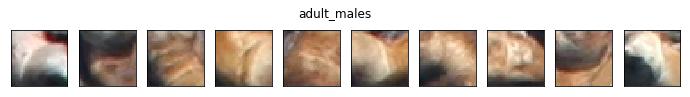

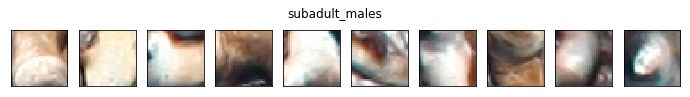

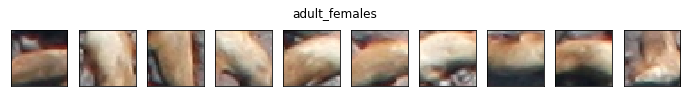

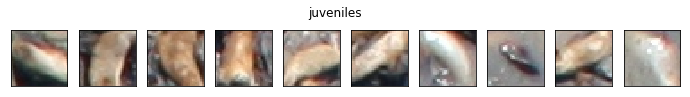

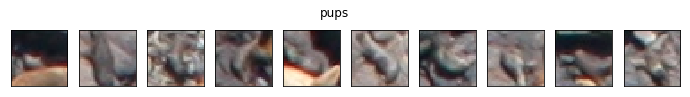

In [21]:
for lion_class in classes:
    f, ax = plt.subplots(1,10,figsize=(12,1.5))
    f.suptitle(lion_class)
    axes = ax.flatten()
    j = 0
    for a in axes:
        a.set_xticks([])
        a.set_yticks([])
        for i in range(j,len(x)):
            if y[i] == lion_class:
                j = i+1
                a.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
                break